## 1. Environment Setup
### 1.1. Imports

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import gc
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D,
                                     Reshape, GRU, Dense, Dropout, Bidirectional, Layer, Activation)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

### 1.2. Configuration

In [4]:
BASE_INPUT_DIR = '/content/drive/MyDrive/fma_project/'
AUDIO_DIR = os.path.join(BASE_INPUT_DIR, 'fma_small/')
METADATA_DIR = os.path.join(BASE_INPUT_DIR, 'fma_metadata/')

WORK_DIR = '/content/drive/MyDrive/fma_project/new/rcnn/'
CACHE_DIR = os.path.join(WORK_DIR, 'crnn_cache_final/')
os.makedirs(CACHE_DIR, exist_ok=True)

# Audio and Spectrogram Parameters
SAMPLE_RATE = 22050
TRACK_DURATION = 30.0
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# CRNN Model Parameters
SEGMENT_DURATION = 5.0
SAMPLES_PER_SEGMENT = int(SAMPLE_RATE * SEGMENT_DURATION)
SEGMENTS_PER_TRACK = int(TRACK_DURATION // SEGMENT_DURATION)

# File Paths
TRAIN_DATA_PATH = os.path.join(CACHE_DIR, 'train_spectrograms.npz')
TEST_DATA_PATH = os.path.join(CACHE_DIR, 'test_spectrograms.npz')
MODEL_PATH = os.path.join(WORK_DIR, 'crnn_model_final.h5')
LABEL_ENCODER_PATH = os.path.join(WORK_DIR, 'crnn_label_encoder.joblib')

print("Configuration for Method B (CRNN) is complete.")

Configuration for Method B (CRNN) is complete.


## 2. Data Loading and Preparation

In [5]:
def load_metadata(metadata_dir):
    tracks = pd.read_csv(os.path.join(metadata_dir, 'tracks.csv'), index_col=0, header=[0, 1])
    tracks.columns = ['_'.join(col).strip() for col in tracks.columns.values]
    small_tracks = tracks[tracks['set_subset'] == 'small'].copy()
    small_tracks = small_tracks.dropna(subset=['track_genre_top'])
    return small_tracks

tracks_df = load_metadata(METADATA_DIR)
le = LabelEncoder()
tracks_df['genre_encoded'] = le.fit_transform(tracks_df['track_genre_top'])
joblib.dump(le, LABEL_ENCODER_PATH)
train_df_full, test_df = train_test_split(
    tracks_df, test_size=0.2, random_state=42, stratify=tracks_df['genre_encoded']
)
print(f"Data split into {len(train_df_full)} training and {len(test_df)} testing samples.")

Data split into 6400 training and 1600 testing samples.


## 3. Data Preprocessing for CRNN
### 3.1. Spectrogram Extraction

In [6]:
def create_spectrogram_dataset(df, cache_path):
    if os.path.exists(cache_path):
        print(f"Loading cached spectrograms from {cache_path}...")
        with np.load(cache_path, allow_pickle=True) as data:
            if all(key in data for key in ['X', 'y', 'track_ids']):
                return data['X'], data['y'], data['track_ids']
            else:
                print("Cache file is incomplete. Regenerating dataset...")

    print("Creating spectrogram segments...")
    all_segments, all_labels, all_track_ids = [], [], []

    for track_id, row in tqdm(df.iterrows(), total=len(df), desc="Processing Tracks"):
        tid_str = f'{track_id:06d}'
        file_path = os.path.join(AUDIO_DIR, tid_str[:3], tid_str + '.mp3')
        if not os.path.exists(file_path): continue

        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION, mono=True)
            if len(y) < int(TRACK_DURATION * sr):
                y = librosa.util.fix_length(y, size=int(TRACK_DURATION * sr))

            for i in range(SEGMENTS_PER_TRACK):
                segment = y[i*SAMPLES_PER_SEGMENT : (i+1)*SAMPLES_PER_SEGMENT]
                mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT)
                db_spec = librosa.power_to_db(mel_spec, ref=np.max)
                all_segments.append(db_spec)
                all_labels.append(row['genre_encoded'])
                all_track_ids.append(track_id)
        except Exception as e:
            print(f"Skipping corrupted file {file_path}: {e}")

    X = np.array(all_segments, dtype=np.float16)[..., np.newaxis]
    y = np.array(all_labels, dtype=np.int32)
    track_ids = np.array(all_track_ids)

    print(f"Saving spectrograms to {cache_path}...")
    np.savez_compressed(cache_path, X=X, y=y, track_ids=track_ids)
    return X, y, track_ids

X_train_all, y_train_all, track_ids_train_all = create_spectrogram_dataset(train_df_full, TRAIN_DATA_PATH)
X_test, y_test, track_ids_test = create_spectrogram_dataset(test_df, TEST_DATA_PATH)

Loading cached spectrograms from /content/drive/MyDrive/fma_project/new/rcnn/crnn_cache_final/train_spectrograms.npz...
Loading cached spectrograms from /content/drive/MyDrive/fma_project/new/rcnn/crnn_cache_final/test_spectrograms.npz...


### 3.2. Balancing the Training Data

In [7]:
processed_train_df = pd.DataFrame({'track_id': track_ids_train_all}).drop_duplicates().set_index('track_id')
processed_train_df = processed_train_df.join(train_df_full['genre_encoded'])

genre_counts = processed_train_df['genre_encoded'].value_counts()
min_count = genre_counts.min()

balanced_track_ids = processed_train_df.groupby('genre_encoded').sample(n=min_count, random_state=42).index
train_indices = np.where(np.isin(track_ids_train_all, balanced_track_ids))[0]
X_train = X_train_all[train_indices]
y_train = y_train_all[train_indices]

print(f"\nOriginal training segments: {len(X_train_all)} | Balanced training segments: {len(X_train)}")
del X_train_all, y_train_all, track_ids_train_all; gc.collect()


Original training segments: 31398 | Balanced training segments: 27024


66

## 4. CRNN Model Implementation
### 4.1. SpecAugment Layer


In [8]:
class SpecAugment(Layer):
    def __init__(self, freq_mask_param, time_mask_param, **kwargs):
        super(SpecAugment, self).__init__(**kwargs)
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
    def call(self, inputs, training=None):
        if not training: return inputs
        input_squeezed = tf.squeeze(inputs, axis=-1)
        input_shape = tf.shape(input_squeezed)
        batch_size, freq_max, time_max = input_shape[0], input_shape[1], input_shape[2]
        # Freq Mask
        f = tf.random.uniform([], 0, self.freq_mask_param, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, freq_max - f, dtype=tf.int32)
        freq_mask = tf.concat([tf.ones((f0, time_max)), tf.zeros((f, time_max)), tf.ones((freq_max - f0 - f, time_max))], axis=0)
        # Time Mask
        t = tf.random.uniform([], 0, self.time_mask_param, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, time_max - t, dtype=tf.int32)
        time_mask = tf.concat([tf.ones((freq_max, t0)), tf.zeros((freq_max, t)), tf.ones((freq_max, time_max - t0 - t))], axis=1)
        mask = tf.expand_dims(freq_mask * time_mask, -1)
        return inputs * tf.cast(mask, dtype=inputs.dtype)

### 4.2. CRNN Architecture

In [14]:
def build_crnn_model(input_shape, num_genres):
    l2_reg = 5e-6
    crnn_input = Input(shape=input_shape)
    x = SpecAugment(freq_mask_param=25, time_mask_param=35)(crnn_input)

    for filters in [64, 128, 256]:
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x); x = Activation('relu')(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x); x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.4)(x)

    x = Reshape((-1, 256))(x)

    gru_output = Bidirectional(GRU(128, return_sequences=False))(x)

    x = Dropout(0.5)(gru_output)
    outputs = Dense(num_genres, activation='softmax', dtype='float32')(x)

    model = Model(inputs=crnn_input, outputs=outputs, name='CRNN_Model_v5')
    return model

num_genres = len(le.classes_)

### 4.3. Model Training

In [16]:
print("\nTraining CRNN model...")
start_time = time.time()

if os.path.exists(MODEL_PATH):
    print(f"Model file found at '{MODEL_PATH}'. Loading pre-trained model...")
    crnn_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'SpecAugment': SpecAugment})
    print("Model loaded successfully. Skipping training phase.")
    training_time = 0.0
    history = None
else:
    print(f"No model file found at '{MODEL_PATH}'. Starting new training...")
    input_shape = X_train.shape[1:]

    crnn_model = build_crnn_model(input_shape, num_genres)

    total_steps = (len(X_train) // 64) * 200
    lr_schedule = CosineDecay(initial_learning_rate=1e-3, decay_steps=total_steps, alpha=1e-6)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    crnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    crnn_model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True),
        ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    history = crnn_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=64,
        epochs=200,
        callbacks=callbacks
    )
    training_time = time.time() - start_time
    print(f"CRNN training complete in {training_time:.2f} seconds.")


Training CRNN model...
Model file found at '/content/drive/MyDrive/fma_project/new/rcnn/crnn_model_final.h5'. Loading pre-trained model...


Model loaded successfully. Skipping training phase.


## 5. Evaluation
### 5.1. Prediction Aggregation

In [17]:
segment_preds = crnn_model.predict(X_test, batch_size=128)

test_results = pd.DataFrame({
    'track_id': track_ids_test,
    'true_label': y_test
})

for i, genre in enumerate(le.classes_):
    test_results[f'pred_prob_{i}'] = segment_preds[:, i]

track_level_preds = test_results.groupby('track_id').mean()
y_pred_final = np.argmax(track_level_preds[[f'pred_prob_{i}' for i in range(num_genres)]].values, axis=1)
y_true_final = track_level_preds['true_label'].astype(int)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1395s 22s/step


### 5.2. Final Performance

In [18]:
print("-" * 50)
print("Final CRNN Model Performance (Track-Level)")
print("-" * 50)
accuracy = accuracy_score(y_true_final, y_pred_final)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_final, y_pred_final, target_names=le.classes_))

--------------------------------------------------
Final CRNN Model Performance (Track-Level)
--------------------------------------------------
Final Test Accuracy: 0.6146

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.68      0.70      0.69       175
 Experimental       0.50      0.47      0.48       168
         Folk       0.67      0.77      0.71       167
      Hip-Hop       0.77      0.71      0.74       160
 Instrumental       0.52      0.64      0.57       143
International       0.68      0.75      0.71       166
          Pop       0.42      0.21      0.28       165
         Rock       0.59      0.68      0.63       161

     accuracy                           0.61      1305
    macro avg       0.60      0.61      0.60      1305
 weighted avg       0.60      0.61      0.60      1305



### 5.3. Confusion Matrix

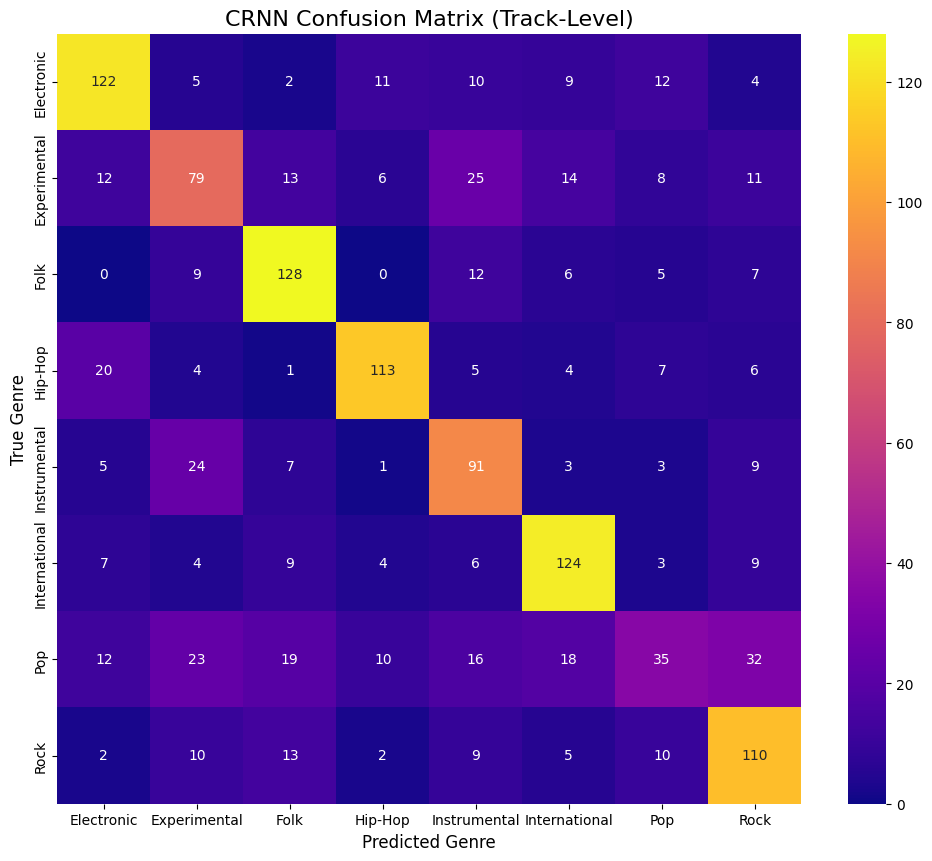

In [19]:
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CRNN Confusion Matrix (Track-Level)', fontsize=16)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.show()